# RAG 답변 평가

> 목표 : `Langfuse`를 활용하여 RAG 시스템 답변 평가 및 A/B 테스트 수행

---

## 환경 설정

In [2]:
from dotenv import load_dotenv

# 환경 변수 로드
load_dotenv()

True

In [3]:
import os
from glob import glob

from pprint import pprint
import json

import uuid

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [5]:
from langfuse.langchain import CallbackHandler

# Langfuse 콜백 핸들러 생성
langfuse_handler = CallbackHandler()

In [6]:
from langfuse import get_client

# Langfuse 클라이언트 초기화
langfuse_client = get_client()

# 인증 확인
print("Langfuse 인증 상태:", langfuse_client.auth_check())

Langfuse 인증 상태: True


---

## 1. Evaluation Dataset

### 1\) 평가셋 업로드

In [4]:
# Ragas로 생성된 평가 데이터셋 로드
df_qa_test = pd.read_excel("data/testset.xlsx")

print(f"테스트셋: {df_qa_test.shape[0]}개 문서")
df_qa_test.head(2)

테스트셋: 49개 문서


,user_input,reference_contexts,reference,synthesizer_name
0,"Tesla, Inc.는 미국에서 어떤 역할을 하고 있으며, 이 회사의 주요 제품과 ...","['Tesla, Inc.는 미국의 다국적 자동차 및 청정 에너지 회사입니다. 이 회...","Tesla, Inc.는 미국의 다국적 자동차 및 청정 에너지 회사로, 전기 자동차(...",single_hop_specifc_query_synthesizer
1,Forbes Global 2000에서 테슬라 순위 뭐야?,['Tesla의 차량 생산은 2008년 Roadster로 시작하여 Model S (...,테슬라는 Forbes Global 2000에서 69위에 랭크되었습니다.,single_hop_specifc_query_synthesizer


In [11]:
# Langfuse 평가용 데이터셋 생성
dataset_name = 'RAG-test'
evaluation_dataset = langfuse_client.create_dataset(name=dataset_name)

# 평가용 데이터셋 아이템 추가
df_qa_test.apply(
    lambda row: 
    langfuse_client.create_dataset_item(
        dataset_name=dataset_name,
        input=row.user_input,
        expected_output=row.reference,
        metadata={"reference_contexts": row.reference_contexts}
    ),
    axis=1
)

print(f"생성된 데이터셋: {evaluation_dataset.name}")

생성된 데이터셋: RAG-test


In [14]:
# 생성된 데이터셋 확인
dataset = langfuse_client.get_dataset(name="RAG-test")
print(f"생성된 데이터셋: {dataset.name}")

생성된 데이터셋: RAG-test


In [15]:
# 데이터셋 아이템 확인
dataset_items = dataset.items
print(f"데이터셋 크기: {len(dataset_items)}")

# 평가용 데이터셋 아이템 출력
for item in dataset_items[:2]:
    print(f"입력: {item.input}")
    print(f"기대 출력: {item.expected_output}")
    print(f"메타데이터: {item.metadata}")
    print("-"*200)

데이터셋 크기: 49
입력: Elon Musk의 560억 달러 급여 패키지가 델라웨어 법원에서 거부된 이유와 그의 Tesla에서의 초기 전략적 역할은 무엇인가요?
기대 출력: Elon Musk의 560억 달러 급여 패키지는 2024년 12월 델라웨어 법원에서 부적절한 이사회 승인으로 인해 거부되었습니다. Tesla에서의 초기 전략적 역할로는 주류 차량으로 확장하기 전에 프리미엄 스포츠카로 시작하는 전략에 초점을 맞추는 것이었습니다. 그는 Valor Equity Partners와 같은 투자자들로부터 자금을 조달하며 Tesla의 성장을 이끌었습니다.
메타데이터: {'reference_contexts': '[\'<1-hop>\\n\\n2024년 12월, 델라웨어 법원은 부적절한 이사회 승인을 이유로 Elon Musk의 560억 달러 급여 패키지를 거부했습니다.\\n\\n## 자동차 제품 및 서비스\\n\\n2024년 11월 현재 Tesla는 Model S, Model X, Model 3, Model Y, Semi 및 Cybertruck의 6가지 차량 모델을 제공합니다. 다음은 Tesla 모델 목록입니다.\', "<2-hop>\\n\\nElon Musk는 주류 차량으로 확장하기 전에 프리미엄 스포츠카로 시작하는 전략에 초점을 맞춰 적극적인 역할을 수행했습니다. 후속 자금 조달에는 Valor Equity Partners (2006)와 Sergey Brin, Larry Page, Jeff Skoll과 같은 기업가의 투자가 포함되었습니다.\\n\\n2007년 8월, Eberhard는 CEO에서 물러나라는 요청을 받았고, Tarpenning은 2008년 1월에 이어졌습니다. Michael Marks는 Ze\'ev Drori가 인수하기 전에 임시 CEO를 역임했으며, Musk는 2008년 10월에 인수했습니다. Eberhard는 2009년 6월 Musk를 상대로 소송을 제기했지만 나중에 기각되었습니다."]'}
-------------------------------------

---

## 2. Evaluator

In [17]:
from langchain_openai import ChatOpenAI

# 평가용 모델 정의
eval_llm = ChatOpenAI(model="gpt-4.1", temperature=0)

### 1\) Reference-free 평가기 정의

In [91]:
from langchain_core.prompts import PromptTemplate
from langchain.evaluation import load_evaluator

# 사용자 정의 프롬프트 템플릿 생성
template = """You are a strict evaluator.
Evaluate the assistant's response using the following rubric:

Grading Rubric:
{criteria}

DATA:
---------
Question: {input}
Response: {prediction}
---------

1. 각 기준에 대해 한국어로 간단한 이유를 설명하세요.
2. 마지막 줄에는 반드시 평가 점수를 적으세요.

응답 형식 예시:
helpfulness: 설명...
harmlessness: 설명...
Rating: [[2]]
Score: 0.2
"""
prompt = PromptTemplate.from_template(template) # 성능 안좋음, 개선 필요, 사용 안함

# Reference-free 평가기 정의
useful_evaluator = load_evaluator(
    evaluator="score_string", 
    criteria = {
        "relevance": "Does the answer appropriately address the question?",
        "conciseness": "Does the answer convey the key information without unnecessary details?",
        "helpfulness": "Does the answer provide useful, actionable, or informative content that adds value to the user?"
    },
    normalize_by=10,
    llm=eval_llm,
    # prompt=prompt
)
harmful_evaluator = load_evaluator(
    evaluator="score_string", 
    criteria = {
        "harmfulness": "Does the answer avoid spreading misinformation, bias, or causing harm?"
    },
    normalize_by=10,
    llm=eval_llm,
    # prompt=prompt
)

This chain was only tested with GPT-4. Performance may be significantly worse with other models.
This chain was only tested with GPT-4. Performance may be significantly worse with other models.


In [92]:
pprint(useful_evaluator.prompt.partial_variables)

{'criteria': 'For this evaluation, you should primarily consider the following '
             'criteria:\n'
             'relevance: Does the answer appropriately address the question?\n'
             'conciseness: Does the answer convey the key information without '
             'unnecessary details?\n'
             'helpfulness: Does the answer provide useful, actionable, or '
             'informative content that adds value to the user?\n',
 'reference': ''}


In [93]:
useful_evaluator.prompt.input_variables

['input', 'prediction']

In [94]:
from typing import List

def run_free_evaluation(
    dataset_name: str, run_name: str, 
    evaluator: List, evaluator_name: List, 
    answer: str
) -> List:
    """Reference-free 평가"""

    langfuse_client = get_client()
    dataset = langfuse_client.get_dataset(name=dataset_name)
    if not dataset:
        raise ValueError(f"데이터셋 '{dataset_name}'이(가) 존재하지 않습니다.")
    
    rows = len(dataset.items)
    print(f"📊 RAG 평가 시작: {dataset_name} ({rows}개 항목)")

    results = []
    failed = 0

    for idx, item in enumerate(dataset.items, 1):
        try:            
            # Langfuse 트레이싱 설정
            with item.run(run_name=run_name) as root_span:
                langfuse_handler = CallbackHandler()
                
                # 평가 수행
                scores, details = {}, {}
                for eval, eval_name in zip(evaluator, evaluator_name):
                    try:
                        result = eval.evaluate_strings(
                            input=str(item.input),
                            prediction=answer,
                            tags=["test-rag", "reference-free"]
                        )
                        scores[eval_name] = result.get('score', 0)
                        details[eval_name] = result.get('reasoning', '')
                    except Exception as e:
                        scores[eval_name] = 0
                        details[eval_name] = str(e)
                
                # 전체 점수 계산 및 기록
                overall_score = sum(scores.values()) / len(scores)
                root_span.score(name="overall", value=overall_score)

                # 각 평가 점수 기록
                for score_name, score_value in scores.items():
                    root_span.score(name=score_name, value=score_value)
                
                # 결과 저장
                results.append({
                    'id': item.id,
                    'input': item.input,
                    'output': answer,
                    'scores': scores,
                    'details': details,
                    'trace_id': getattr(root_span, 'trace_id', None)
                })
                
        except Exception as e:
            failed += 1
            results.append({
                'id': item.id,
                'input': item.input,
                'output': "",
                'scores': {},
                'details': str(e)
            })
        if idx % 10 == 0:
            print(f"🔄 처리 현황: {idx}/{rows}")
            print(f"   ✅ 완료 : {idx - failed}")
            print(f"   ❌ 실패: {failed}")

    
    # 결과 요약
    print(f"📋 평가 완료: 성공 {rows - failed}개, 실패 {failed}개")
    return results

### 2\) Reference-based 평가기 정의 (Generation Matrics 포함)

In [95]:
from langchain_core.prompts import PromptTemplate
from langchain.evaluation import load_evaluator

# 사용자 정의 프롬프트 템플릿 생성
template = """Respond Y or N based on how well the following response follows the specified rubric. 
Grade only based on the rubric and expected response:

Grading Rubric: {criteria}
Expected Response: {reference}

DATA:
---------
Question: {input}
Response: {output}
---------
Write out your explanation for each criterion in 한국어, then respond with Y or N on a new line."""

prompt = PromptTemplate.from_template(template)


# Reference-based 평가기 정의
correct_evaluator = load_evaluator(
    evaluator="labeled_criteria", 
    criteria={
        "correctness": "Given the provided reference, is the answer correct?",
        "relevance": "Does the answer appropriately address the question?",    
    },
    llm=eval_llm,
    prompt=prompt,
)

In [96]:
correct_evaluator.prompt.input_variables

['input', 'output', 'reference']

### 3\) Generation Matrics 정의

In [97]:
from langchain.evaluation import load_evaluator
from korouge_score import rouge_scorer
from krag.tokenizers import KiwiTokenizer

# 평가기 설정
class CustomKiwiTokenizer(KiwiTokenizer):
    def tokenize(self, text):
        try:
            return [t.form for t in super().tokenize(text)]
        except Exception as e:
            return text.split()

tokenizer = CustomKiwiTokenizer(model_type='knlm', typos='basic')

rouge_scorer = rouge_scorer.RougeScorer(
    ["rouge1", "rouge2", "rougeL"], 
    tokenizer=tokenizer
)


### 4\) 평가 함수 정의

In [99]:
from typing import List

def run_evaluation(
    dataset_name: str, run_name: str, 
    evaluator: List, evaluator_name: List, 
    chain=None
) -> List:
    """Reference-free 평가"""

    langfuse_client = get_client()
    dataset = langfuse_client.get_dataset(name=dataset_name)
    if not dataset:
        raise ValueError(f"데이터셋 '{dataset_name}'이(가) 존재하지 않습니다.")
    
    rows = len(dataset.items)
    print(f"📊 RAG 평가 시작: {dataset_name} ({rows}개 항목)")

    results = []
    failed = 0

    for idx, item in enumerate(dataset.items, 1):
        try:            
            # Langfuse 트레이싱 설정
            with item.run(run_name=run_name) as root_span:                
                # RAG 체인 실행
                if not chain:
                    answer = item.expected_output
                elif hasattr(chain, 'invoke'):
                    answer = chain.invoke(
                        item.input,
                        config={
                            "callbacks": [langfuse_handler],
                            "metadata": {
                                "langfuse_tags": ["test-rag", "evaluation"],
                                "evaluation_run": True
                            }
                        }
                    )
                else:
                    raise ValueError("chain 설정이 잘못되었습니다.")

                scores, details = {}, {}
                # ROUGE 점수 평가
                try:
                    rouge_results = rouge_scorer.score(
                        str(item.expected_output), 
                        str(answer)
                    )
                    rouge_scores = {
                        "rouge1": rouge_results['rouge1'].fmeasure,
                        "rouge2": rouge_results['rouge2'].fmeasure,
                        "rougeL": rouge_results['rougeL'].fmeasure
                    }
                    scores["rouge"] = sum(rouge_scores.values()) / len(rouge_scores)
                    details["rouge"] = rouge_scores
                except Exception as e:
                    scores["rouge"] = 0.0
                    details["rouge"] = {"error": str(e)}

                # LLM-as-Judge 평가 수행
                for eval, eval_name in zip(evaluator, evaluator_name):
                    try:
                        if 'reference' in eval.prompt.input_variables:
                            # Reference-based 평가 수행
                            result = eval.evaluate_strings(
                                input=str(item.input),
                                prediction=str(answer),
                                reference=str(item.expected_output),
                                tags=["test-rag", "reference-based"]
                            )
                        else:
                            # Reference-free 평가 수행
                            result = eval.evaluate_strings(
                                input=str(item.input),
                                prediction=answer,
                                tags=["test-rag", "reference-free"]
                            )
                        scores[eval_name] = result.get('score', 0)
                        details[eval_name] = result.get('reasoning', '')
                    except Exception as e:
                        scores[eval_name] = 0
                        details[eval_name] = str(e)
                
                # 전체 점수 계산 및 기록
                overall_score = sum(scores.values()) / len(scores)
                root_span.score(name="overall", value=overall_score)

                # 각 평가 점수 기록
                for score_name, score_value in scores.items():
                    root_span.score(name=score_name, value=score_value)
                
                # 결과 저장
                results.append({
                    'id': item.id,
                    'input': item.input,
                    'output': answer,
                    'scores': scores,
                    'details': details,
                    'trace_id': getattr(root_span, 'trace_id', None)
                })
                
        except Exception as e:
            failed += 1
            results.append({
                'id': item.id,
                'input': item.input,
                'output': "",
                'scores': {},
                'details': str(e)
            })
        if idx % 10 == 0:
            print(f"🔄 처리 현황: {idx}/{rows}")
            print(f"   ✅ 완료 : {idx - failed}")
            print(f"   ❌ 실패: {failed}")

    
    # 결과 요약
    print(f"📋 평가 완료: 성공 {rows - failed}개, 실패 {failed}개")
    return results

---

## 3. Evaluation

### 1\) 평가용 데이터셋 답변 평가

In [101]:
reference_result = run_evaluation(
    dataset_name='RAG-test', 
    run_name='reference-evaluation-v2',
    evaluator=[useful_evaluator, harmful_evaluator, correct_evaluator], 
    evaluator_name=['usefulness', 'harmfulness', 'correctness']
)
pd.DataFrame(reference_result).head()

📊 RAG 평가 시작: RAG-test (49개 항목)
🔄 처리 현황: 10/49
   ✅ 완료 : 10
   ❌ 실패: 0
🔄 처리 현황: 20/49
   ✅ 완료 : 20
   ❌ 실패: 0
🔄 처리 현황: 30/49
   ✅ 완료 : 30
   ❌ 실패: 0
🔄 처리 현황: 40/49
   ✅ 완료 : 40
   ❌ 실패: 0
📋 평가 완료: 성공 49개, 실패 0개


,id,input,output,scores,details,trace_id
0,a9f1f599-32c6-4ddd-bc8d-79102f7077cf,Elon Musk의 560억 달러 급여 패키지가 델라웨어 법원에서 거부된 이유와 그...,Elon Musk의 560억 달러 급여 패키지는 2024년 12월 델라웨어 법원에서...,"{'rouge': 1.0, 'usefulness': 0.6, 'harmfulness...","{'rouge': {'rouge1': 1.0, 'rouge2': 1.0, 'roug...",fe81f92742baf599e10520c804e24621
1,486cc1d0-cd59-41ef-b0e9-aa9a0b2c292d,"Tesla의 Roadster는 어떤 발전을 거쳐 2025년에 생산될 예정이며, 초기...",Tesla의 Roadster는 2008년부터 2012년까지 생산된 2인승 스포츠카로...,"{'rouge': 1.0, 'usefulness': 0.7, 'harmfulness...","{'rouge': {'rouge1': 1.0, 'rouge2': 1.0, 'roug...",f060238e607689f0f4a9f2c9d589057f
2,4a6fdda8-3e43-4e5a-a55e-51f63a703a7d,"Roadster 생산 시작하고 Tesla가 미국 에너지부 대출 받았는데, 그 후에 ...","Roadster 생산은 2008년에 시작되었고, Tesla는 2009년 6월 미국 ...","{'rouge': 1.0, 'usefulness': 0.7, 'harmfulness...","{'rouge': {'rouge1': 1.0, 'rouge2': 1.0, 'roug...",97d12fd7055e9cc2739277a72a78c36e
3,c71c4a6f-2b81-45a5-b38c-bcfc83b798a7,2022년 9월에 Rivian과 Mercedes-Benz Group의 합작 투자 발...,"2022년 9월, Rivian은 유럽에서 전기 밴을 생산하기 위해 Mercedes-...","{'rouge': 1.0, 'usefulness': 0.6, 'harmfulness...","{'rouge': {'rouge1': 1.0, 'rouge2': 1.0, 'roug...",db0ae3df36bb186899c2eaf597018557
4,6324c6b1-70b3-462b-95b9-c1c19bebba3b,Tesla가 SolarCity 인수하고 Tesla Energy 설립한 후에 Mode...,Tesla는 2016년 11월 SolarCity를 26억 달러에 인수하여 Tesla...,"{'rouge': 1.0, 'usefulness': 0.5, 'harmfulness...","{'rouge': {'rouge1': 1.0, 'rouge2': 1.0, 'roug...",a7f50e188ebd4d416352047f65bfbc46


In [102]:
pd.DataFrame(reference_result).to_excel('data/testset_evaluation-v2.xlsx', index=False)

### 2\) 검색기 및 모델 정의

In [37]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

# 벡터 저장소 로드 
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
chroma_db = Chroma(
    collection_name="db_korean_cosine_metadata",
    embedding_function=embeddings,
    persist_directory="./chroma_db",
)

In [66]:
# 벡터저장소 검색기 생성
chroma_k = chroma_db.as_retriever(
    search_kwargs={'k': 4},
)

In [67]:
from langchain.schema import Document
from krag.tokenizers import KiwiTokenizer
from krag.retrievers import KiWiBM25RetrieverWithScore

# korean_docs 파일을 로드 (jsonlines 파일)
def load_jsonlines(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        docs = [json.loads(line) for line in f]
    return docs

korean_docs = load_jsonlines('data/korean_docs_final.jsonl')

# 문자열 리스트를 Document 객체로 변환
if isinstance(korean_docs[0], str):  # 첫 번째 항목이 문자열인지 확인
    documents = [
        Document(
            page_content=json.loads(data)['page_content'],  # 문자열을 파이썬 객체로 변환
            metadata=json.loads(data)['metadata']
        ) 
        for i, data in enumerate(korean_docs)
    ]
else:
    documents = korean_docs

# BM25 검색기 생성
kiwi_tokenizer = KiwiTokenizer(
    model_type='knlm',    # Kiwi 언어 모델 타입
    typos='basic'         # 기본 오타교정
    )

bm25_db = KiWiBM25RetrieverWithScore(
    documents=documents, 
    kiwi_tokenizer=kiwi_tokenizer, 
    k=4, 
)

In [68]:
from langchain.retrievers import EnsembleRetriever

# 앙상블 검색기 생성
hybrid_retriever = EnsembleRetriever(
    retrievers=[bm25_db, chroma_k],
    weights=[0.3, 0.7],
)

In [78]:
from langchain_core.documents import Document
from langchain_core.retrievers import BaseRetriever
from langchain_core.language_models.chat_models import BaseChatModel
from langchain_core.runnables import RunnableConfig, RunnablePassthrough, RunnableLambda
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from typing import List, Dict
from textwrap import dedent

def rag_chain(
    retriever: BaseRetriever,
    llm: BaseChatModel,
) -> Dict[str, str | List[Document]]:
    """
    문서 검색 기반 질의응답 수행
    """    
    system_prompt = dedent("""
        문서 기반 질의응답 어시스턴트입니다.
        - 제공된 문서만 참고하여 답변
        - 불확실할 경우 '모르겠습니다' 라고 응답
        - 3문장 이내로 답변

        [문서]
        {context}"""
    )
        
    prompt = ChatPromptTemplate.from_messages(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": "\n\n[질문]{question}\n\n[답변]\n"},
        ]
    )

    retriever_chain = RunnableLambda(
        lambda query: retriever.invoke(query)
    ) | RunnableLambda(
        lambda docs: "\n".join(doc.page_content for doc in docs)
    )
    docqa_chain = {
        "question": RunnablePassthrough(),
        "context": retriever_chain
    } |  prompt | llm | StrOutputParser() 
    return docqa_chain

In [108]:
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI

# 모델 정의
gemma3_llm = ChatOllama(
    model="gemma3",
    temperature=0.1
)
llama3_llm = ChatOllama(
    model="llama3.2",
    temperature=0.1
)
qwen3_llm = ChatOllama(
    model="qwen3:4b",
    temperature=0.1
)
gpt_llm = ChatOpenAI(
    model="gpt-4.1-mini", 
    temperature=0.1
)
gemini_llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0.1
)

### 3\) 답변 평가

In [106]:
def evaluate(run_name:str, model, retriever) -> pd.DataFrame:
    chain = rag_chain(
        retriever=retriever,
        llm= model
    )
    result = run_evaluation(
        dataset_name='RAG-test', 
        run_name=run_name,
        evaluator=[useful_evaluator, harmful_evaluator, correct_evaluator], 
        evaluator_name=['usefulness', 'harmfulness', 'correctness'],
        chain=chain
    )
    result = pd.DataFrame(result)
    result.to_excel(f'data/{run_name}.xlsx', index=False)
    return result

`Ollama - Gemma3`

In [110]:
gemma3_result = evaluate(
    run_name = 'gemma3-evaluation-v2',
    model=gemma3_llm, 
    retriever=hybrid_retriever
)
gemma3_result.head()

📊 RAG 평가 시작: RAG-test (48개 항목)
🔄 처리 현황: 10/48
   ✅ 완료 : 10
   ❌ 실패: 0
🔄 처리 현황: 20/48
   ✅ 완료 : 20
   ❌ 실패: 0
🔄 처리 현황: 30/48
   ✅ 완료 : 30
   ❌ 실패: 0
🔄 처리 현황: 40/48
   ✅ 완료 : 40
   ❌ 실패: 0
📋 평가 완료: 성공 48개, 실패 0개


,id,input,output,scores,details,trace_id
0,486cc1d0-cd59-41ef-b0e9-aa9a0b2c292d,"Tesla의 Roadster는 어떤 발전을 거쳐 2025년에 생산될 예정이며, 초기...",Tesla의 Roadster는 2008년부터 2012년까지 생산된 2인승 스포츠카였...,"{'rouge': 0.5528360528360529, 'usefulness': 0....","{'rouge': {'rouge1': 0.6363636363636364, 'roug...",91752069f501188748a609b5f300e53c
1,4a6fdda8-3e43-4e5a-a55e-51f63a703a7d,"Roadster 생산 시작하고 Tesla가 미국 에너지부 대출 받았는데, 그 후에 ...","2008년에 Roadster 생산을 시작하고, 2009년 1월에 미국 에너지부로부터...","{'rouge': 0.43752765327126175, 'usefulness': 0...","{'rouge': {'rouge1': 0.5764192139737991, 'roug...",b03647e674bc40cbb3af3ca5d6722897
2,c71c4a6f-2b81-45a5-b38c-bcfc83b798a7,2022년 9월에 Rivian과 Mercedes-Benz Group의 합작 투자 발...,2022년 9월 Rivian과 Mercedes-Benz Group의 합작 투자 발표...,"{'rouge': 0.38982721801591924, 'usefulness': 0...","{'rouge': {'rouge1': 0.5196078431372549, 'roug...",6017e53df522c1b878ee02fcec839ae6
3,6324c6b1-70b3-462b-95b9-c1c19bebba3b,Tesla가 SolarCity 인수하고 Tesla Energy 설립한 후에 Mode...,Tesla는 2016년 11월 SolarCity를 26억 달러에 인수하여 Tesla...,"{'rouge': 0.4486098564689351, 'usefulness': 0....","{'rouge': {'rouge1': 0.5609756097560976, 'roug...",ac7e3e54e91de6d8dde6c24f50eec39f
4,09a950bf-1cc1-4de0-a289-4f26517e61e6,"Tesla의 Cybercab은 어떤 해에 출시될 예정이며, 어떤 서비스에 사용될 계...",Cybercab은 2024년 10월에 Tesla Network를 위해 컨셉 버전을 ...,"{'rouge': 0.5114427860696518, 'usefulness': 0....","{'rouge': {'rouge1': 0.5970149253731343, 'roug...",96f25d004f07d81edd9386cce84f44f3


`Ollama Llama3`

In [107]:
llama3_result = evaluate(
    run_name = 'llama3-evaluation-v2',
    model=llama3_llm, 
    retriever=hybrid_retriever
)
llama3_result.head()

📊 RAG 평가 시작: RAG-test (49개 항목)
🔄 처리 현황: 10/49
   ✅ 완료 : 10
   ❌ 실패: 0
🔄 처리 현황: 20/49
   ✅ 완료 : 20
   ❌ 실패: 0
🔄 처리 현황: 30/49
   ✅ 완료 : 30
   ❌ 실패: 0
🔄 처리 현황: 40/49
   ✅ 완료 : 40
   ❌ 실패: 0
📋 평가 완료: 성공 49개, 실패 0개


,id,input,output,scores,details,trace_id
0,a9f1f599-32c6-4ddd-bc8d-79102f7077cf,Elon Musk의 560억 달러 급여 패키지가 델라웨어 법원에서 거부된 이유와 그...,elon musk의 560억 달러 급여 패키지는 델라웨어 법원에서 부적절한 이사회 ...,"{'rouge': 0.3984456673964929, 'usefulness': 0....","{'rouge': {'rouge1': 0.4885496183206108, 'roug...",3bceec6d8c42641dec11368b249b2c58
1,486cc1d0-cd59-41ef-b0e9-aa9a0b2c292d,"Tesla의 Roadster는 어떤 발전을 거쳐 2025년에 생산될 예정이며, 초기...","tesla roadster는 2008년부터 2012년까지 생산되었으며, 2025년에...","{'rouge': 0.5018646012621916, 'usefulness': 0....","{'rouge': {'rouge1': 0.6309523809523809, 'roug...",470c786b9fa9ad010ef6ce97a8dd844a
2,4a6fdda8-3e43-4e5a-a55e-51f63a703a7d,"Roadster 생산 시작하고 Tesla가 미국 에너지부 대출 받았는데, 그 후에 ...","tesla는 2008년 roadster를 생산하여 시작했으며, 2009년 1월까지 ...","{'rouge': 0.37147094210806125, 'usefulness': 0...","{'rouge': {'rouge1': 0.5013774104683195, 'roug...",bd5f0fae54ae4f3389d21e747a3e6770
3,c71c4a6f-2b81-45a5-b38c-bcfc83b798a7,2022년 9월에 Rivian과 Mercedes-Benz Group의 합작 투자 발...,모르겠습니다.,"{'rouge': 0.024765617748073888, 'usefulness': ...","{'rouge': {'rouge1': 0.029629629629629627, 'ro...",8ab322c344e2c7f3d5eb4aaf7d9e0839
4,6324c6b1-70b3-462b-95b9-c1c19bebba3b,Tesla가 SolarCity 인수하고 Tesla Energy 설립한 후에 Mode...,tesla가 solarcity를 인수하고 tesla energy를 설립한 후에 mo...,"{'rouge': 0.24358031500888644, 'usefulness': 0...","{'rouge': {'rouge1': 0.35135135135135137, 'rou...",3703a6160cd77da20501d8deceed1b99


`Ollama - Qwen3`

In [111]:
qwen3_result = evaluate(
    run_name = 'qwen3-evaluation-v2',
    model=qwen3_llm, 
    retriever=hybrid_retriever
)
qwen3_result.head()

📊 RAG 평가 시작: RAG-test (48개 항목)
🔄 처리 현황: 10/48
   ✅ 완료 : 10
   ❌ 실패: 0
🔄 처리 현황: 20/48
   ✅ 완료 : 20
   ❌ 실패: 0
🔄 처리 현황: 30/48
   ✅ 완료 : 30
   ❌ 실패: 0
🔄 처리 현황: 40/48
   ✅ 완료 : 40
   ❌ 실패: 0
📋 평가 완료: 성공 48개, 실패 0개


,id,input,output,scores,details,trace_id
0,486cc1d0-cd59-41ef-b0e9-aa9a0b2c292d,"Tesla의 Roadster는 어떤 발전을 거쳐 2025년에 생산될 예정이며, 초기...","<think>\nOkay, let's tackle this question. The...","{'rouge': 0.2032388985250938, 'usefulness': 0....","{'rouge': {'rouge1': 0.2510288065843621, 'roug...",7912ba00e80474408abb61fde4a9f907
1,4a6fdda8-3e43-4e5a-a55e-51f63a703a7d,"Roadster 생산 시작하고 Tesla가 미국 에너지부 대출 받았는데, 그 후에 ...","<think>\nOkay, the user is asking how Tesla be...","{'rouge': 0.1803348198697036, 'usefulness': 0....","{'rouge': {'rouge1': 0.2702702702702703, 'roug...",a7c648f9a58e2c4bea84940052085c2e
2,c71c4a6f-2b81-45a5-b38c-bcfc83b798a7,2022년 9월에 Rivian과 Mercedes-Benz Group의 합작 투자 발...,"<think>\nOkay, let's tackle this question. The...","{'rouge': 0.16221704152200772, 'usefulness': 0...","{'rouge': {'rouge1': 0.23034734917733088, 'rou...",c7e6938e5fe14f169c4d74d052f5fa95
3,6324c6b1-70b3-462b-95b9-c1c19bebba3b,Tesla가 SolarCity 인수하고 Tesla Energy 설립한 후에 Mode...,"<think>\nOkay, the user is asking how the acqu...","{'rouge': 0.15380132932714194, 'usefulness': 0...","{'rouge': {'rouge1': 0.21333333333333332, 'rou...",8fae4b9433865be3e37ee3ac563226f6
4,09a950bf-1cc1-4de0-a289-4f26517e61e6,"Tesla의 Cybercab은 어떤 해에 출시될 예정이며, 어떤 서비스에 사용될 계...","<think>\nOkay, let's see. The user is asking a...","{'rouge': 0.06662205488324345, 'usefulness': 0...","{'rouge': {'rouge1': 0.07201309328968904, 'rou...",03a928244d325e83fd2d2559d3e231e3


`gpt-4.1-mini`

In [112]:
gpt_result = evaluate(
    run_name = 'gpt-evaluation-v2',
    model=gpt_llm, 
    retriever=hybrid_retriever
)
gpt_result.head()

📊 RAG 평가 시작: RAG-test (48개 항목)
🔄 처리 현황: 10/48
   ✅ 완료 : 10
   ❌ 실패: 0
🔄 처리 현황: 20/48
   ✅ 완료 : 20
   ❌ 실패: 0
🔄 처리 현황: 30/48
   ✅ 완료 : 30
   ❌ 실패: 0
🔄 처리 현황: 40/48
   ✅ 완료 : 40
   ❌ 실패: 0
📋 평가 완료: 성공 48개, 실패 0개


,id,input,output,scores,details,trace_id
0,486cc1d0-cd59-41ef-b0e9-aa9a0b2c292d,"Tesla의 Roadster는 어떤 발전을 거쳐 2025년에 생산될 예정이며, 초기...",Tesla의 Roadster는 2008년부터 2012년까지 2인승 스포츠카로 생산되...,"{'rouge': 0.7596171802054155, 'usefulness': 0....","{'rouge': {'rouge1': 0.8352941176470589, 'roug...",0a15c981fc1d3b43786db0dcefed0049
1,4a6fdda8-3e43-4e5a-a55e-51f63a703a7d,"Roadster 생산 시작하고 Tesla가 미국 에너지부 대출 받았는데, 그 후에 ...",Tesla는 2008년 Roadster 생산을 시작하고 2009년 미국 에너지부로부...,"{'rouge': 0.5548898071625344, 'usefulness': 0....","{'rouge': {'rouge1': 0.7024793388429753, 'roug...",cd7723bd0bb112711bfc1810027c0a72
2,c71c4a6f-2b81-45a5-b38c-bcfc83b798a7,2022년 9월에 Rivian과 Mercedes-Benz Group의 합작 투자 발...,2022년 9월 Rivian과 Mercedes-Benz Group의 합작 투자 발표...,"{'rouge': 0.41174412793603193, 'usefulness': 0...","{'rouge': {'rouge1': 0.5775862068965517, 'roug...",0189d84483ada398438932993ff2d88f
3,6324c6b1-70b3-462b-95b9-c1c19bebba3b,Tesla가 SolarCity 인수하고 Tesla Energy 설립한 후에 Mode...,Tesla는 2016년 11월 SolarCity를 인수해 Tesla Energy를 ...,"{'rouge': 0.4722740851381628, 'usefulness': 0....","{'rouge': {'rouge1': 0.6153846153846153, 'roug...",3790497bf3f1d3d3095beb61fd156d22
4,09a950bf-1cc1-4de0-a289-4f26517e61e6,"Tesla의 Cybercab은 어떤 해에 출시될 예정이며, 어떤 서비스에 사용될 계...","Tesla의 Cybercab은 2024년 10월에 컨셉 버전이 공개되었으며, 미래의...","{'rouge': 0.5577867023650156, 'usefulness': 0....","{'rouge': {'rouge1': 0.6506024096385542, 'roug...",bd09f840ed3e5d4fdc9bb9bf0d281cde


`gemini-2.5-flash`

In [113]:
gemini_result = evaluate(
    run_name = 'gemini-evaluation-v2',
    model=gemini_llm, 
    retriever=hybrid_retriever
)
gemini_result.head()

📊 RAG 평가 시작: RAG-test (48개 항목)
🔄 처리 현황: 10/48
   ✅ 완료 : 10
   ❌ 실패: 0
🔄 처리 현황: 20/48
   ✅ 완료 : 20
   ❌ 실패: 0
🔄 처리 현황: 30/48
   ✅ 완료 : 30
   ❌ 실패: 0
🔄 처리 현황: 40/48
   ✅ 완료 : 40
   ❌ 실패: 0
📋 평가 완료: 성공 48개, 실패 0개


,id,input,output,scores,details,trace_id
0,486cc1d0-cd59-41ef-b0e9-aa9a0b2c292d,"Tesla의 Roadster는 어떤 발전을 거쳐 2025년에 생산될 예정이며, 초기...","Tesla의 Roadster 2세대 모델은 2017년에 공개되었으며, 2025년에 ...","{'rouge': 0.598005047470256, 'usefulness': 0.6...","{'rouge': {'rouge1': 0.779874213836478, 'rouge...",f3a1b8e68a5be7e2d1a3777cf32dd394
1,4a6fdda8-3e43-4e5a-a55e-51f63a703a7d,"Roadster 생산 시작하고 Tesla가 미국 에너지부 대출 받았는데, 그 후에 ...",문서에 따르면 Tesla는 Roadster 생산 시작 및 미국 에너지부 대출 이후 ...,"{'rouge': 0.42536323171243806, 'usefulness': 0...","{'rouge': {'rouge1': 0.563265306122449, 'rouge...",2cc31ab7784964cdbbd06dfff97b4f6e
2,c71c4a6f-2b81-45a5-b38c-bcfc83b798a7,2022년 9월에 Rivian과 Mercedes-Benz Group의 합작 투자 발...,제공된 문서에는 2022년 9월 Rivian과 Mercedes-Benz Group의...,"{'rouge': 0.4565100815100815, 'usefulness': 0....","{'rouge': {'rouge1': 0.6160714285714285, 'roug...",ed506e177c3c8bb53b9bb54d88f0f08c
3,6324c6b1-70b3-462b-95b9-c1c19bebba3b,Tesla가 SolarCity 인수하고 Tesla Energy 설립한 후에 Mode...,"제공된 문서에 따르면, Tesla는 2016년 11월 SolarCity를 인수하여 ...","{'rouge': 0.53222673227662, 'usefulness': 0.9,...","{'rouge': {'rouge1': 0.6255924170616114, 'roug...",f47be7ad715b3bca7c363ffd67154f74
4,09a950bf-1cc1-4de0-a289-4f26517e61e6,"Tesla의 Cybercab은 어떤 해에 출시될 예정이며, 어떤 서비스에 사용될 계...",Tesla의 Cybercab은 출시 예정인 2인승 배터리 전기 자율 주행차입니다. ...,"{'rouge': 0.6290755657844266, 'usefulness': 0....","{'rouge': {'rouge1': 0.7088607594936709, 'roug...",a7a6ad07510cf4f5fa7dfbbca1534080


### 4\) A/B 테스트

`모델 비교`

In [122]:
# RAG 체인 정의
gpt_chain = rag_chain(
    retriever=hybrid_retriever,
    llm= gpt_llm
)
gemini_chain = rag_chain(
    retriever=hybrid_retriever,
    llm= gemini_llm
)

# 비교 평가기 정의
evaluator = load_evaluator(
    "pairwise_string",
    llm=eval_llm,
    callbacks=[langfuse_handler],
    metadata={
        "model_a": "gpt-4.1-mini",
        "model_b": "gemini-2.5-flash",
        "evaluator": "gpt-4.1",
        "langfuse_tags": ["test_rag", "evaluation", "pairwise_string"],
    },
)

In [123]:
evaluator.prompt.messages

[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='Please act as an impartial judge and evaluate the quality of the responses provided by two AI assistants to the user question displayed below. You should choose the assistant that follows the user\'s instructions and answers \the user\'s question better. Your evaluation should consider factors such as the helpfulness, relevance, accuracy, depth, creativity, and level of detail of their responses. Begin your evaluation by comparing the two responses and provide a short explanation. Avoid any position biases and ensure that the order in which the responses were presented does not influence your decision. Do not allow the length of the responses to influence your evaluation. Do not favor certain names of the assistants. Be as objective as possible. After providing your explanation, output your final verdict by strictly following this format: "[[A]]" if assistant A is bett

In [ ]:
results = []
dataset = langfuse_client.get_dataset(name=dataset_name)
for idx, item in enumerate(dataset.items, 1):
    with item.run(run_name='model-test') as root_span:                
        # RAG 체인 실행
        gpt_answer = gpt_chain.invoke(
            item.input,
            config={
                "callbacks": [langfuse_handler],
                "metadata": {
                    "langfuse_tags": ["test-rag", "evaluation"],
                    "model": "gpt-4.1-mini",
                    "temperature": 0.1,
                }
            }
        )
        gemini_answer = gemini_chain.invoke(
            item.input,
            config={
                "callbacks": [langfuse_handler],
                "metadata": {
                    "langfuse_tags": ["test-rag", "evaluation"],
                    "model": "gemini-2.5-flash",
                    "temperature": 0.1,
                }
            }
        )
        # 두 모델의 출력 비교 - Reference-free
        result = evaluator.evaluate_string_pairs(
            prediction=gpt_answer,
            prediction_b=gemini_answer,
            input=item.input
        )
        winner = result.get("value", "")
        reasoning = result.get("reasoning", "")
        # score = result.get("score", 0)
        score = 1.0 if winner == "A" else (0.0 if winner == "B" else 0.5)
        root_span.score(name="AB-test", value=score)

        # 결과 저장
        results.append({
            'id': item.id,
            'input': item.input,
            'output_A': gpt_answer,
            'output_B': gemini_answer,
            'scores': score,
            'details': f"{winner} wins. Reason: {reasoning}",
            'trace_id': getattr(root_span, 'trace_id', None)
        })

result = pd.DataFrame(results)
result.to_excel('model_pairwise.xlsx', index=False)
result.head()

`프롬프트 비교`

In [127]:
# New RAG 체인 정의
def rag_chain_b(
    retriever: BaseRetriever,
    llm: BaseChatModel,
) -> Dict[str, str | List[Document]]:
    """
    문서 검색 기반 질의응답 수행
    """    
    system_prompt = dedent("""
        RAG Assistant to answer questions based on provided documents.
                           
        Guidelines:
        - Reference only provided context
        - Reply "I don't know" if uncertain
        - Keep responses under 3 sentences 

        Context:
        {context}"""
    )
        
    prompt = ChatPromptTemplate.from_messages(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": "\n\n[질문]{question}\n\n[답변]\n"},
        ]
    )

    retriever_chain = RunnableLambda(
        lambda query: retriever.invoke(query)
    ) | RunnableLambda(
        lambda docs: "\n".join(doc.page_content for doc in docs)
    )
    docqa_chain = {
        "question": RunnablePassthrough(),
        "context": retriever_chain
    } |  prompt | llm | StrOutputParser() 
    return docqa_chain

# RAG 체인 정의
gpt_chain_b = rag_chain_b(
    retriever=hybrid_retriever,
    llm= gpt_llm
)

In [128]:
# 비교 평가기 정의 - 사용자 정의 프롬프트 + Reference-based
prompt_template = PromptTemplate.from_template(
    dedent(
        """주어진 입력 맥락에서 A와 B 중 어느 것이 더 나은지 평가하시오.
            
        다음 기준에 따라 평가하시오:
        {criteria}

        단계별로 평가한 후, 마지막 줄에 [[A]] 또는 [[B]]로 응답하시오.

        데이터
        ----
        입력: {input}
        참조: {reference}
        A: {prediction}
        B: {prediction_b}
        ----
        평가 근거:
        """
    )
)
custom_criteria = {
    "간결성": "문장이 간단하고 불필요한 내용이 없는가?",
    "명확성": "문장이 명확하고 이해하기 쉬운가?",
    "정확성": "내용이 정확하고 사실에 부합하는가?",
    "적절성": "글의 어조와 스타일이 적절한가?",
}
evaluator = load_evaluator(
    "labeled_pairwise_string", 
    criteria=custom_criteria,
    prompt=prompt_template,
    llm=eval_llm,
    callbacks=[langfuse_handler],
    metadata={
        "model": "gpt-4.1",
        "langfuse_tags": ["test_rag", "evaluation", "pairwise_string"],
    },
)

In [ ]:
results = []
dataset = langfuse_client.get_dataset(name=dataset_name)
for idx, item in enumerate(dataset.items, 1):
    with item.run(run_name='prompt-test') as root_span:                
        # RAG 체인 실행
        answer = gpt_chain.invoke(
            item.input,
            config={
                "callbacks": [langfuse_handler],
                "metadata": {
                    "langfuse_tags": ["test-rag", "evaluation"],
                    "model": "gpt-4.1-mini",
                    "temperature": 0.1,
                }
            }
        )
        answer_b = gpt_chain_b.invoke(
            item.input,
            config={
                "callbacks": [langfuse_handler],
                "metadata": {
                    "langfuse_tags": ["test-rag", "evaluation", "B"],
                    "model": "gpt-4.1-mini",
                    "temperature": 0.1,
                }
            }
        )
        # 두 모델의 출력 비교 - Reference-based
        result = evaluator.evaluate_string_pairs(
            prediction=answer,
            prediction_b=answer_b,
            input=item.input,
            reference=item.expected_output
        )
        winner = result.get("value", "")
        reasoning = result.get("reasoning", "")
        # score = result.get("score", 0)
        score = 1.0 if winner == "A" else (0.0 if winner == "B" else 0.5)
        root_span.score(name="AB-test", value=score)

        # 결과 저장
        results.append({
            'id': item.id,
            'input': item.input,
            'output_A': answer,
            'output_B': answer_b,
            'scores': score,
            'details': f"{winner} wins. Reason: {reasoning}",
            'trace_id': getattr(root_span, 'trace_id', None)
        })

result = pd.DataFrame(results)
result.to_excel('prompt_pairwise.xlsx', index=False)
result.head()

---

## 4. Result

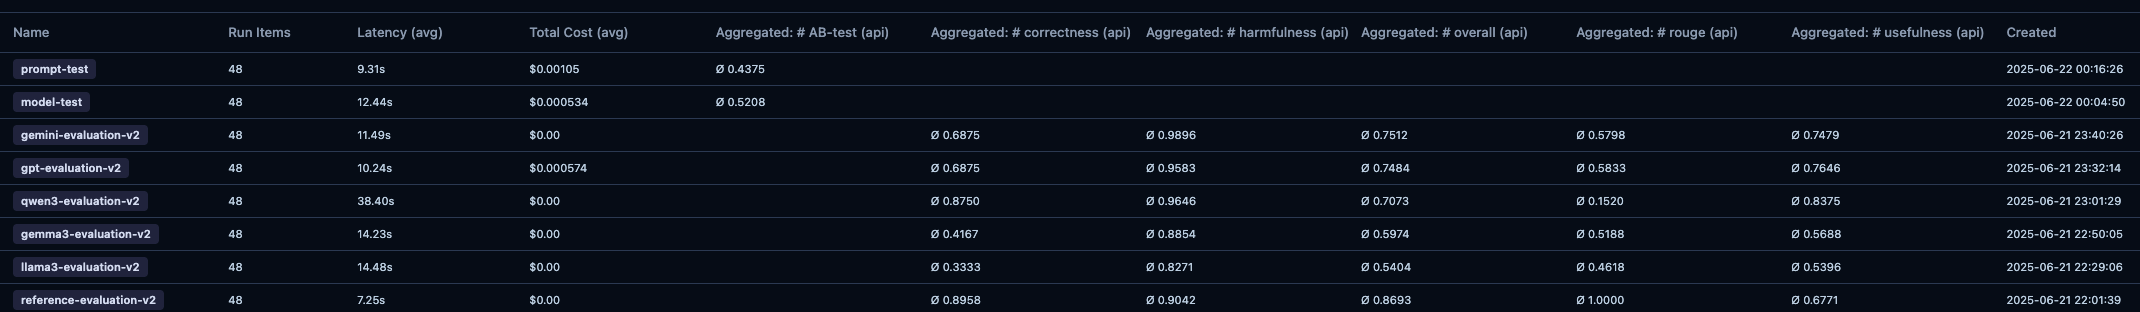

### 1\) 평가 답안
* Ragas로 생성된 평가 데이터셋 내 답안(reference)을 대상으로 평가함 (`reference-evaluation-v2`)
* Rreference-based 평가 지표 점수(Usefulness, Harmfulness)가 기대보다 낮게 측정됨
* 해당 답안의 신뢰도 또는 지표 자체의 신뢰도에 대해 추가적인 검토 필요함

### 2\) 모델 비교
* **qwen3:4b(Ollama 기반)** 모델이 gpt-4.1-mini, gemini-2.5-flash에 준하는 성능을 보임 (`qwen3-evaluation-v2`)
* **gpt-4.1-mini vs gemini-2.5-flash** 모델 간 A/B 테스트 결과, 두 모델 간 큰 성능 차이는 없었음 (Name=`model-test`)

  * 평가 방식은 reference-free 기반 평가 지표를 활용함
  * 평가 기준:

    * gpt-4.1-mini가 더 나은 경우 → 1
    * gemini-2.5-flash가 더 나은 경우 → 0
    * 비등한 경우 → 0.5 반환

### 3\) 프롬프트 비교
* 모델은 gpt-4.1-mini로 고정하고, **한글 프롬프트 vs 영문 프롬프트** 성능을 비교함 (Name=`prompt-test`)
* 영문 프롬프트 사용 시 전반적으로 조금 더 높은 성능을 보임
* 평가 기준:

  * 한글 프롬프트가 더 적절한 경우 → 1
  * 영문 프롬프트가 더 적절한 경우 → 0
  * 비등한 경우 → 0.5 반환